Pest Disease Image Classification

In [1]:
# Import all the dependencies

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers


Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

In [2]:
# set the constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import Pest image data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4074 files belonging to 15 classes.


In [4]:
# Store class names into variable
class_names = dataset.class_names
class_names 

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
# Each batch of the image is 32 images, we have 128 batches
len(dataset)

128

In [6]:
# Printing shape of batches
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[14 12 12 12 12 12 14 12 14 14 12 12 14 12 12 12 13 14 12 12 14 12 14 12
 12 12 12 12 12 12 12 14]


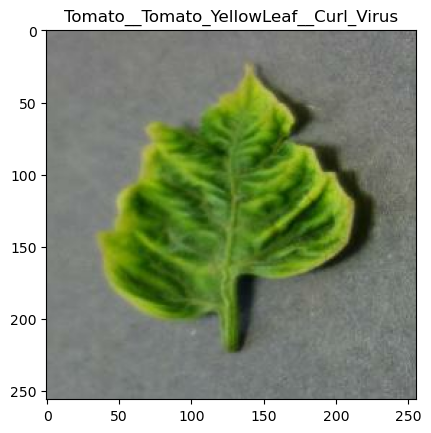

In [7]:
# Print first image (each time image display would be different due to shuffle randomness)
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    # Print image classname
    plt.title(class_names[label_batch[0]])

### Visualize the input data

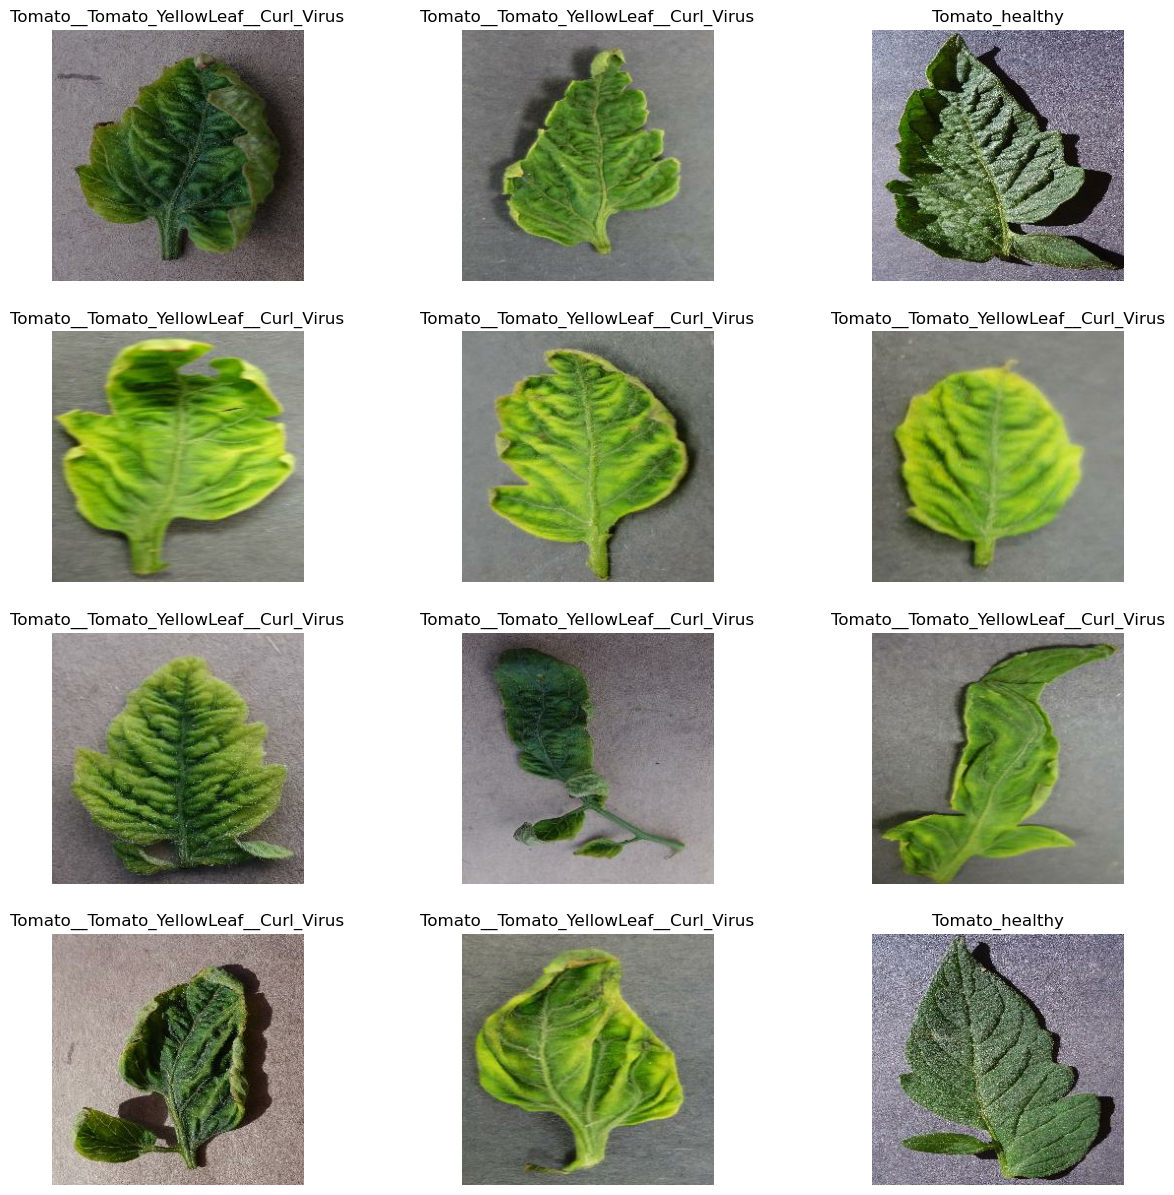

In [8]:
plt.figure(figsize = (15, 15))
# Print first 12 images
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) #convert float32 to uint8 for RGB image
        # Print image classname
        plt.title(class_names[label_batch[i]])
        
        # Turn off axis
        plt.axis('off')

#### Split the dataset 
The Standard test train split (80% train, 20% test)
- 80% ==> training
- 20% ==> 10% validation, 10% test

In [9]:
# Split train dataset
train_size = 0.8
len(dataset)*train_size

102.4

In [10]:
train = dataset.take(102)
len(train)

102

In [11]:
# Store the remaining 20% of the data as test
test_ds = dataset.skip(102)
len(test_ds)

26

In [12]:
val_size=0.1
len(dataset)*val_size

12.8

In [13]:
val_ds = test_ds.take(13)
len(val_ds)

13

In [14]:
test_ds = test_ds.skip(13)
len(test_ds)

13

 Make a function to do the above Test Train Split for us

In [15]:
# Define function to split data
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
# Calling function to split data
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
print(f'train size {len(train_ds)}')
print(f'val size {len(val_ds)}')
print(f'test size {len(test_ds)}')

train size 102
val size 12
test size 14


Cache, Shuffle, and Prefetch the Dataset to improve performance

In [18]:
# Cache data and optimize speed
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Image Preprocessing and Data Augmentation

In [19]:
# Resize and rescale image

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Build the CNN Model

In [21]:
# Define neural network architecture
n_classes = len(class_names)
# input shape = image size, channel
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# Set layers of model
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape, padding='same'), # Convolution + reLu
    layers.MaxPooling2D((2,2)), # Pooling
    # Repeat to increase the number of filters
    layers.Conv2D(64, (3,3), activation = 'relu', padding='same'), # add zero padding to make output same size as input
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(), # Flatten into a feature vector
    layers.Dense(64, activation = 'relu'),
    # softmax normalized probability of classes
    layers.Dense(n_classes,activation = 'softmax'), # FCN output layer of shape (batch_size, n_classes)
    
])
model.build(input_shape = input_shape)

### Visualize the Model Architecture

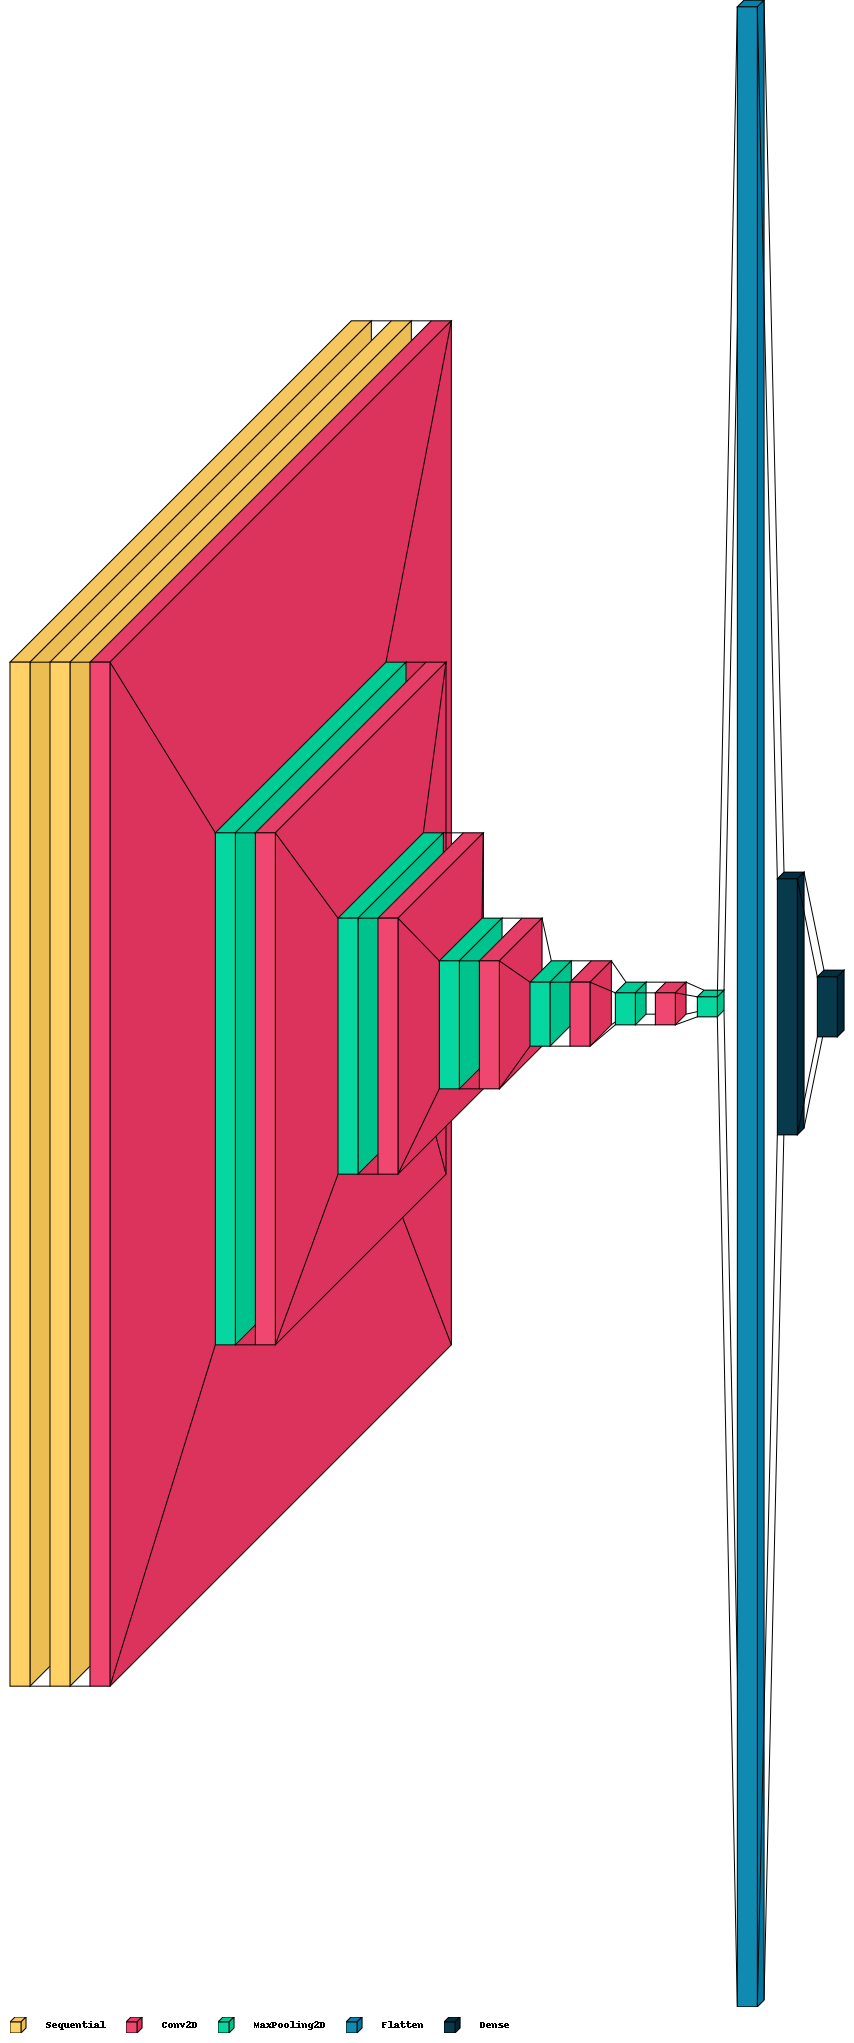

In [22]:
import visualkeras

visualkeras.layered_view(model, legend=True, spacing=20, one_dim_orientation='y', to_file='model_architecture.png') # write the image to file

from IPython.display import Image
Image(filename='model_architecture.png') 

In [23]:
# summary of model to see the number of parameters and output shape
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 256, 256, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 128, 128, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 128, 128, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 64, 64, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 64, 64, 64)         

### Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [24]:
# Compile using optimizer
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
102/102 [==============================] - 11s 55ms/step - loss: 0.9495 - accuracy: 0.6255 - val_loss: 0.3694 - val_accuracy: 0.8490
Epoch 2/50
102/102 [==============================] - 3s 32ms/step - loss: 0.3509 - accuracy: 0.8769 - val_loss: 0.2605 - val_accuracy: 0.9036
Epoch 3/50
102/102 [==============================] - 3s 32ms/step - loss: 0.2449 - accuracy: 0.9152 - val_loss: 0.3218 - val_accuracy: 0.8932
Epoch 4/50
102/102 [==============================] - 3s 32ms/step - loss: 0.1568 - accuracy: 0.9436 - val_loss: 0.1759 - val_accuracy: 0.9375
Epoch 5/50
102/102 [==============================] - 3s 32ms/step - loss: 0.1749 - accuracy: 0.9343 - val_loss: 0.1958 - val_accuracy: 0.9323
Epoch 6/50
102/102 [==============================] - 3s 32ms/step - loss: 0.1327 - accuracy: 0.9510 - val_loss: 0.1093 - val_accuracy: 0.9688
Epoch 7/50
102/102 [==============================] - 3s 32ms/step - loss: 0.1498 - accuracy: 0.9466 - val_loss: 0.1030 - val_accuracy: 0.966

In [26]:
# Evaluate model on test dataset
scores = model.evaluate(test_ds)


14/14 [==============================] - 2s 19ms/step - loss: 0.0706 - accuracy: 0.9754


In [27]:
# First parameter -> loss, second parameter -> accuracy
scores

[0.07063071429729462, 0.9754464030265808]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 102}

In [30]:

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
# Look at all epoch accuracy
history.history['accuracy'][-5:] # show accuracy for last 5 epochs


[0.9839605093002319,
 0.9895126223564148,
 0.9870450496673584,
 0.9913633465766907,
 0.9885873198509216]

In [32]:
# Storing accuracy and loss into variables for visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

 Plot the Training and Validation Accuracy and Loss over each epoch

Text(0.5, 1.0, 'Training and Validation Loss')

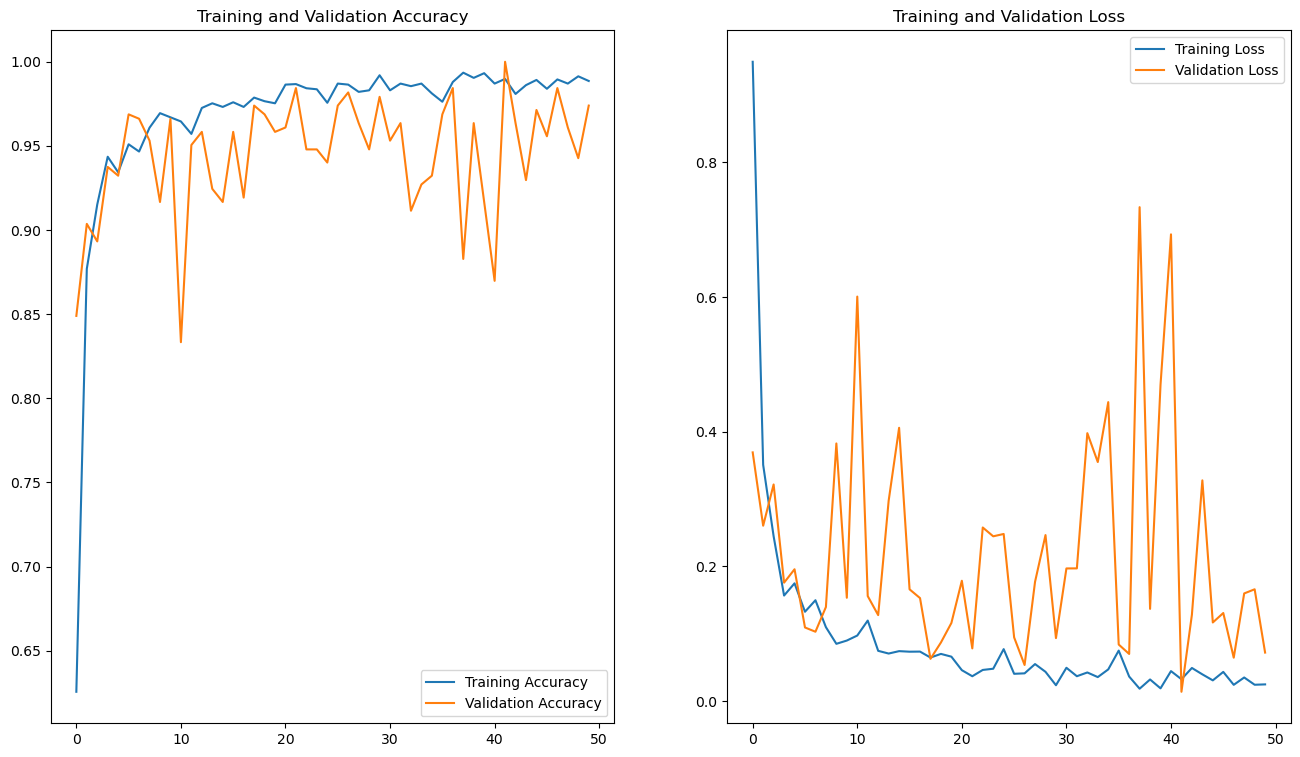

In [33]:
# Visualize training and validation accuracy
plt.figure(figsize = (16,9))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Visualize training and validation loss
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

Make Prediction on a sample image

actual label: Tomato_healthy
predicted label: Tomato_healthy


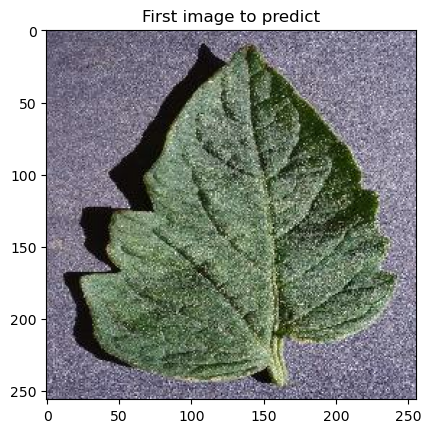

In [34]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.title("First image to predict")
    plt.imshow(first_image)
    plt.savefig('first_image.png')
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Make function for Model Inference

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

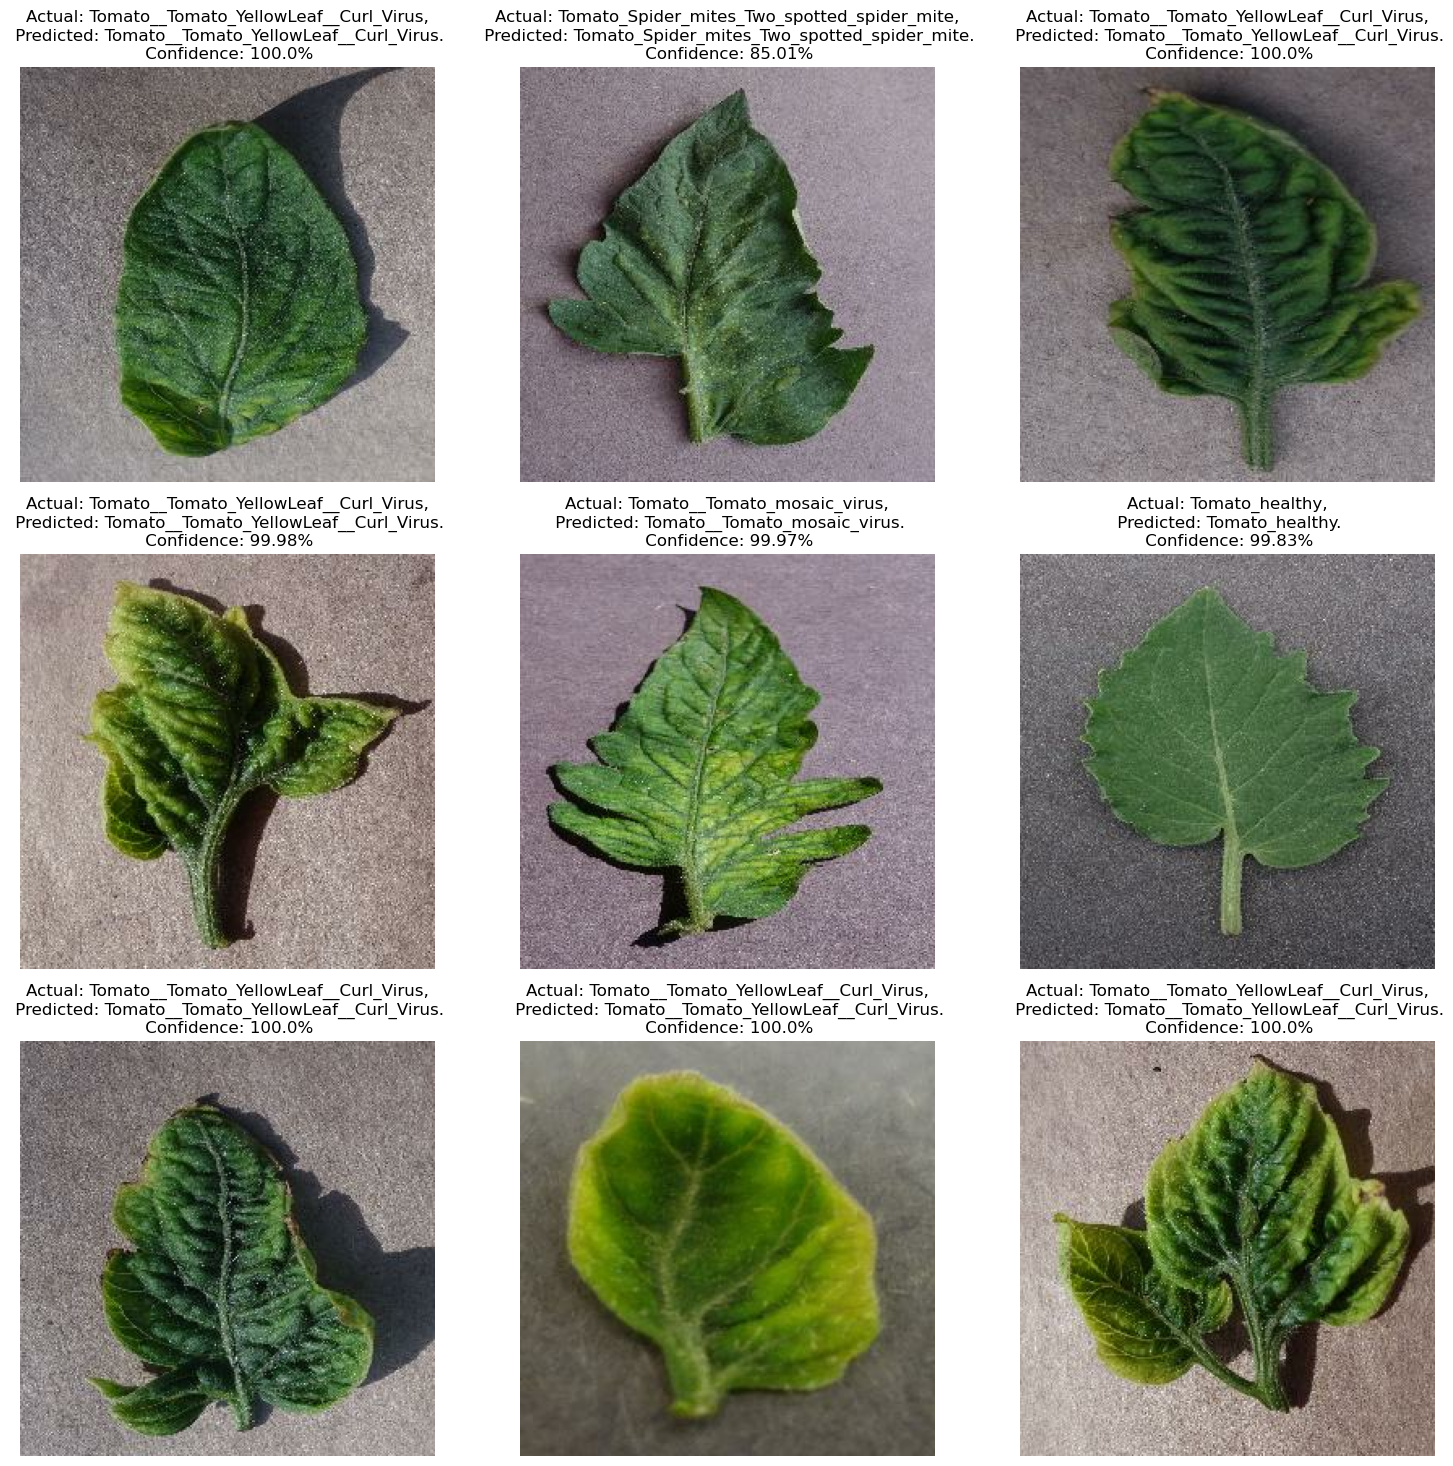

In [36]:
# Visualize predictions
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.savefig("predictions.png")
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.tight_layout()
        plt.axis("off")

Saving the Model

In [37]:
# Save model
model_version = 1
model.save(f"../saved_models/{model_version}")

import os
# # to save the latest model by adding 1 to the number
# model_version = max(int(i) for i in os.listdir("../saved_models") + [0]) + 1 
# model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: saved_models/1\assets
